<a href="https://colab.research.google.com/github/NULabTMN/homework-3-gmac98/blob/main/classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Text Classification

In class, we spent some time on text classification, including naive Bayes classifiers.  We focused on these models not only because they are simple to implement and fairly effective, but also because of their similarity to widely used bag-of-words retrieval models such as BM25 and query likelihood.

Your task is to write a naive Bayes text categorization system to predict whether movie reviews are positive or negative.  The data for this **sentiment analysis** task were first assembled and published in Bo Pang and Lillian Lee, &ldquo;A Sentimental Education: Sentiment Analysis Using Subjectivity Summarization Based on Minimum Cuts&rdquo;, _Proceedings of the Association for Computational Linguistics_, 2004.

## Loading the data

First we load the training, development, and test splits of this dataset.

In [1]:
import json
from urllib.request import urlopen
import numpy as np
import matplotlib.pyplot as plt
import math
import random
from collections import Counter

In [2]:
# Read one JSON record per line
def read_jsonl(f):
  res = []
  for line in f:
    res.append(json.loads(line))
  return res

If you're working offline, you could modify this code to read from the copies of the data in the repository.

In [3]:
train = read_jsonl(urlopen("https://github.com/dasmiq/cs6200-hw3/blob/main/train.json?raw=true"))
dev = read_jsonl(urlopen("https://github.com/dasmiq/cs6200-hw3/blob/main/dev.json?raw=true"))
test = read_jsonl(urlopen("https://github.com/dasmiq/cs6200-hw3/blob/main/test.json?raw=true"))

print(len(train))
print(len(dev))
print(len(test))

1600
200
200


Each of these subsets of the data is a list of documents, and each document has a unique identifier (`id`) and text (`text`). The training and development documents, in addition, have been labeled with a `class`.

In [4]:
print(train[0])
print(dev[0])
print(test[0])

{'id': '12178', 'class': 'neg', 'text': "the sequel to the fugitive ( 1993 ) , u . s marshals is an average thriller using it's association with the fugitive just so it can make a few extra bucks . \ntommy lee jones returns to his role as chief deputy samuel gerard , the grizzly cop who was after harrison ford in the fugitive . \nthis time , he's after fugitive mark sheridan ( snipes ) who the police think killed two fbi agents , but of course he's been set up , and when the police plane escort he ( and gerard ) are riding crashes , he makes a run for it , gerard not so hot on his tail . \nwhat follows is about 2 hours of action , brought to us by the director of executive decision ( 1995 ) , another film curiously involving a plane . \nwhen comparing this movie to the fugitive , the prequel is far superior . \nbut even on it's own , u . s marshals is a pretty lousy movie . \nwhile the original was reasonably intelligent , and had a fugitive to root for , the audience feels strangely d

## Collecting term statistics

The text has been pre-tokenized and lower-cased.  All you have to do to get the individual terms in a review is to split the tokens by whitespace, a sequence of spaces and/or newlines.

In [5]:
## To diplay all output in window screen
from IPython.display import HTML, display

def set_css():
  display(HTML('''
  <style>
    pre {
        white-space: pre-wrap;
    }
  </style>
  '''))
get_ipython().events.register('pre_run_cell', set_css)

In [6]:
def generate_tuples_from_file(training_file_path):
  """
  Generates tuples from list of dictionary
  Return:
    a list of tuples of strings formatted [(id, label, example_text), (id, label, example_text)....]
  """
  list1 = []
  for dic in training_file_path:
    l1 = []
    for key, val in dic.items():
        l1.append(val)
    v1 = tuple(l1)
    list1.append(v1)
  return list1

listOfTrainingExamples = generate_tuples_from_file(train)

In [7]:
## TODO: Write a function to convert a document into a collection of terms and their counts.
## Convert the lists of documents in the training, development, and test sets into these collections of terms and counts.
def tokenize1(data):
    return data.split()

def term_statistics(examples, tokenize):
    positive_lines = []
    negative_lines = []
    
    for i in examples:
        if i[1] == "pos":
            positive_lines.append(i[2])
        if i[1] == "neg":
            negative_lines.append(i[2])
            
    N_positive = len(positive_lines)                   #Number of positive docs
    N_negative = len(negative_lines)                   #Number of negative docs
    
    positive_vocabulary_list = []
    for line in positive_lines:
        words = tokenize(line)
        temp_positive_vocabulary_list = []
        for word in words:
            if word!='':
                temp_positive_vocabulary_list.append(word)  #all words in positive doc
        tpvl = []
        tpvl = set(temp_positive_vocabulary_list)
        for word in tpvl:
            positive_vocabulary_list.append(word)
    
    
    negative_vocabulary_list = []
    for line in negative_lines:
        words = tokenize(line)
        temp_negative_vocabulary_list = []
        for word in words:
            if word!='':
                temp_negative_vocabulary_list.append(word)  #words in negative doc
        tnvl = []
        tnvl = set(temp_negative_vocabulary_list)
        for word in tnvl:
            negative_vocabulary_list.append(word)
            
            
    vocabulary_list = []
    vocabulary_list = positive_vocabulary_list + negative_vocabulary_list   #all words from all docs (including duplicates)
    vocabulary = set(vocabulary_list)                        #unique words from pos and neg doc

    return N_positive, N_negative, vocabulary, positive_vocabulary_list, negative_vocabulary_list

N_positive, N_negative, vocabulary, positive_vocabulary_list, negative_vocabulary_list = term_statistics(listOfTrainingExamples, tokenize1)

The statistics for individual documents will be useful in predicting the class of those documents, e.g., in the test set.

Now, you will collect the statistics used to estimate the parameters of a naive Bayes model.

In [8]:
## TODO: Write a function to take a list of document statistics and produce a dictionary of term counts in each class.
## Your output will look something like this:

# fakeData = {'pos': {'the': 10000, 'and': 800},
#             'neg': {'the': 1001, 'and': 799}}

def termCountDict(positive_vocabulary_list, negative_vocabulary_list):
    positive_word_count = Counter(positive_vocabulary_list)  
    negative_word_count = Counter(negative_vocabulary_list)
    sentimentData = {'pos': positive_word_count, 'neg': negative_word_count}

    return sentimentData
    
sentimentData = termCountDict(positive_vocabulary_list, negative_vocabulary_list)

## Estimating naive Bayes parameters

As we discussed in class, you could use simple maximum-likelihood estimation for naive Bayes parameters, i.e., computing the relative frequency of a term given a class. The problem is that the relative frequency of words not seen in the training data will be zero, e.g., $p(\texttt{aardvark} | \texttt{pos}) = \frac{0}{\textrm{tokens in the positive training data}}$.

To avoid this problem, estimate the parameters with **add-1 (Laplace) smoothing**. In other words, add an additional count of 1 to each word type. Then, to make the probability distribution sum to 1, add a count of 1 for each vocabulary word to the denominator. For our `aardvark` example, we would now have, for vocabulary $V$, $p(\texttt{aardvark} | \texttt{pos}) = \frac{0 + 1}{N_{\texttt{pos}} + 1 \cdot |V|}$


In [9]:
## TODO: Write a function to compute the add-1 smoothed parameters for a naive Bayes model given the term statistics you computed above.
## Collect these parameters for the training set.
def naive(vocabulary, sentimentData, alpha):
    positive_likelihood = {}
    negative_likelihood = {}

    for i in vocabulary:
        positive_likelihood[i] = math.log( (sentimentData['pos'][i] + alpha) / (len(positive_vocabulary_list) + alpha * len(vocabulary)) )
        negative_likelihood[i] = math.log( (sentimentData['neg'][i] + alpha) / (len(negative_vocabulary_list) + alpha * len(vocabulary)) )

    return positive_likelihood, negative_likelihood

positive_likelihood, negative_likelihood = naive(vocabulary, sentimentData, 1)

What terms are likely to be important for prediction?

In [10]:
## TODO: Print a list of the 25 terms with the highest log ratio of positive to negative weight.
p2n_ratio = {}
for i in vocabulary:
    p2n_ratio[i] = positive_likelihood[i] / negative_likelihood[i]

print('25 terms with the highest log ratio of positive to negative weight', sorted(p2n_ratio.items(), key=lambda x: x[1], reverse=True)[:25])

25 terms with the highest log ratio of positive to negative weight [('atrocious', 1.302180758505219), ('jolie', 1.2695013814236602), ('3000', 1.2695013814236602), ('seagal', 1.2695013814236602), ('ludicrous', 1.2641525109012752), ('dud', 1.2601756887390128), ('incoherent', 1.2601756887390128), ('justin', 1.2601756887390128), ('angelina', 1.2601756887390128), ('insulting', 1.250933980117748), ('wielding', 1.2502558715972305), ('shoddy', 1.239648073389705), ('degenerates', 1.239648073389705), ('overwrought', 1.239648073389705), ('chuckle', 1.2380386728556514), ('uninvolving', 1.2380386728556514), ('idiotic', 1.2310745815650717), ('nutty', 1.2282332175081239), ('silverstone', 1.2282332175081239), ('bruckheimer', 1.2282332175081239), ('horrid', 1.2282332175081239), ('tedium', 1.2158568536544883), ('feeble', 1.2158568536544883), ('coyote', 1.2158568536544883), ('hodgepodge', 1.2158568536544883)]


In [11]:
## TODO: Print a list of the 25 terms with the highest log ration of negative to positive weight.
n2p_ratio = {}
for i in vocabulary:
    n2p_ratio[i] = negative_likelihood[i] / positive_likelihood[i]

print('25 terms with the highest log ratio of negative to positive weight', sorted(n2p_ratio.items(), key=lambda x: x[1], reverse=True)[:25])

25 terms with the highest log ratio of negative to positive weight [('outstanding', 1.2772588742848134), ('symbol', 1.2646964445150808), ('lovingly', 1.2560349871785232), ("son's", 1.2560349871785232), ('fashioned', 1.2560349871785232), ('thematic', 1.2468625664196493), ('dread', 1.2371049081709438), ('melancholy', 1.2371049081709438), ('religion', 1.2370176408155211), ('vulnerable', 1.2308066065007344), ('comforts', 1.2266695139817518), ('characteristic', 1.2266695139817518), ('en', 1.2266695139817518), ('masterfully', 1.2266695139817518), ('ideals', 1.2266695139817518), ('astounding', 1.2176046005546983), ('avoids', 1.2176046005546983), ('gattaca', 1.215439022783148), ('methodical', 1.215439022783148), ('exhilarating', 1.215439022783148), ('symbols', 1.215439022783148), ('steady', 1.215439022783148), ('tobey', 1.215439022783148), ('fascination', 1.2105602849041193), ('judges', 1.2032611988477546)]


Now, given the parameters you've estimated, you can make predictions about new documents.

In [12]:
## TODO: Compute the predictions of your model for each document in the development data.
def classify(N_positive, N_negative, data, positive_likelihood, negative_likelihood, tokenize):
    """
    Score a given piece of text
    Return: dict of class: score mappings
    """
    words = tokenize(data)
    test_words = []
    for i in words:
        if i!='':
            if i in positive_likelihood:
              test_words.append(i)
    
    N_doc = N_positive + N_negative                    #Total number of docs

    prior_positive = math.log((N_positive/N_doc))     #Logarithmic Prior
    prior_negative = math.log((N_negative/N_doc))

    positive_value = prior_positive
    negative_value = prior_negative
    for i in test_words:
        positive_value = ( positive_value) + ( positive_likelihood.get(i))
        negative_value = ( negative_value) + ( negative_likelihood.get(i))
        
    # positive_value = np.exp(positive_value)
    # negative_value = np.exp(negative_value)
    predScoreDistribution = {'pos': positive_value, 'neg': negative_value}
    # print(predScoreDistribution)
    if predScoreDistribution['pos'] >= predScoreDistribution['neg']:
        return 'pos'
    else:
        return 'neg'

In [13]:
## TODO: Write a function to compute the accuracy of predictions given correct classes.

devClasses = [x['class'] for x in dev]

listOfDevExamples = generate_tuples_from_file(dev)
devPredictions1 = []
for line in listOfDevExamples:
      devPredictions1.append(classify(N_positive, N_negative, line[2], positive_likelihood, negative_likelihood, tokenize1))

def accuracy(predicted_labels, gold_labels):
    numerator = 0.0
    denominator = len(predicted_labels)
    for i in range(len(gold_labels)):
        if gold_labels[i] == predicted_labels[i]:
            numerator += 1
    return numerator / denominator

accuracy1 = accuracy(devPredictions1, devClasses)
print("1st model, Accuracy:", accuracy1)

1st model, Accuracy: 0.72


In [14]:
## TODO: Compute the predictions of this model on each document in the test set.
listOfTestExamples = generate_tuples_from_file(test)
testPredictions = []
n = 0
key_order = ['id', 'class', 'text']
for line in listOfTestExamples:
      testPredictions.append(classify(N_positive, N_negative, line[1], positive_likelihood, negative_likelihood, tokenize1))
      test[n]['class'] = testPredictions[-1]
      test[n] = {k : test[n][k] for k in key_order}
      n += 1

print(test[0])

{'id': '11471', 'class': 'neg', 'text': 'the lives of older people in the twilight of their years attempting to come to grips with their shared histories and possible futures is a fascinating topic . \nfinding an all-star cast for such a film is a stroke of genius . \ncombining all that with a three-time oscar-winning director ( robert benton of " kramer vs . \nkramer " ) and creating a decidedly mediocre movie is the stuff of disappointment . \nin yet another noir mystery set in hollywood -- how many of these have we seen during the past few years ? \n-- the atmosphere is moody , the actors enjoyable to watch and the story goes nowhere . \nover-70 harry ross ( paul newman ) is a washed up cop-turned-private eye-turned man friday trying to figure out how to live what remains of his life . \nhe\'s screwed up things pretty well ( " i had a wife and daughter . \nnow , i\'m a drunk ) and is at a crossroads . \na couple of years ago , he traveled to mexico to bring back mel ( reese withersp

## Comparing models with hypothesis testing (CS6200 only)

Now that you've built a straightforward naive Bayes model, you can try to improve it. You could try stemming words, or including bigrams or trigrams, or adjusting the hyperparameter for Laplace smoothing, or trying a different smoothing method. What you try is up to you.

In [15]:
## TODO: Try different features and/or smoothing.
## Compute the predictions and the acuracy of your new model on development data.

# Tokenizing and stemming
def tokenize2(data):
    data = data.split()
    result = []
    for i in range(len(data)):
        word = data[i]
        if word.endswith("sses"):
            result.append(word[:-2])
        elif word.endswith("ing"):
            result.append(word[:-3])
        elif word.endswith("ies"):
            result.append(word[:-2])
        elif word.endswith("ss"):
            result.append(word[:-2])
        elif word.endswith("ment"):
            result.append(word[:-4])
        # elif word.endswith("s"):
        #     result.append(word[:-1])
        else:
            result.append(word)
    return result


N_positive2, N_negative2, vocabulary2, positive_vocabulary_list2, negative_vocabulary_list2 = term_statistics(listOfTrainingExamples, tokenize2)
sentimentData2 = termCountDict(positive_vocabulary_list2, negative_vocabulary_list2)

# Adjusting hyperparameter for Laplace smoothing to 4
positive_likelihood2, negative_likelihood2 = naive(vocabulary2, sentimentData2, 4)

devClasses = [x['class'] for x in dev]
listOfDevExamples = generate_tuples_from_file(dev)
devPredictions2 = []
for line in listOfDevExamples:
      devPredictions2.append(classify(N_positive2, N_negative2, line[2], positive_likelihood2, negative_likelihood2, tokenize2))

accuracy2 = accuracy(devPredictions2, devClasses)
print("2nd model, Accuracy:", accuracy2)

2nd model, Accuracy: 0.755


Perhaps your new model will be better than your original naive Bayes model above; perhaps it will be worse. (That won't affect your grade.) Your next step is to implement a permutation test to compare the two models. Refer to the material on the bootstrap and permutation tests at the end of the evaluation lecture.

In [16]:
## TODO: Compute the difference in accuracy between your first naive Bayes model and your new one.

difference = np.abs(accuracy1 - accuracy2)
print('Observed difference : ',difference)

for i in range(0,len(devPredictions1)):
    if devPredictions1[i] == 'pos':
      devPredictions1[i] = 1
    else:
      devPredictions1[i] = 0

for i in range(0,len(devPredictions2)):
    if devPredictions2[i] == 'pos':
      devPredictions2[i] = 1
    else:
      devPredictions2[i] = 0
devPred1 = np.array(devPredictions1)
devPred2 = np.array(devPredictions2)

Observed difference :  0.03500000000000003


In [17]:
## TODO: Write a function that, given two vectors of predictions that have
## the same length, swaps each pair of predictions with probability 0.5.
def permute(y1, y2):
  for i in range(len(y1)):
    rand = random.random()
    if rand > 0.5:
      y1[i], y2[i] = y2[i], y1[i]

  return y1, y2

In [18]:
## TODO: If you run this permute function 500 times on the predictions of your two models,
## it should produce 500 different pairs of vectors.
## Compute the difference in accuracy for each of these 500 pairs, i.e., a vector of 500 differences.
def testingDiff(xs, ys, nmc):
    permutationDifferences = []
    for j in range(nmc):
        y1, y2 = permute(xs, ys)
        diff = np.abs(np.mean(y1) - np.mean(y2))
        permutationDifferences.append(diff)
    return permutationDifferences

permutationDifferences = testingDiff(devPred1, devPred2, 500)
# print(permutationDifferences[:20])

In [19]:
## TODO: Compute the proportion of these differences that are greater than the actual accuracy difference between your two models.
## This proportion is the p-value computed by this permutation test.
k = 0
for i in range(len(permutationDifferences)):
    if permutationDifferences[i] > difference:
      k +=1

print('p-value : ', k/500)

p-value :  0.012


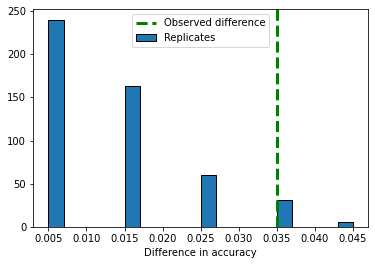

In [20]:
## This code should plot a histogram of the differences between the permuted vectors
## and the location of the observed accuracy difference.
plt.hist(permutationDifferences, 20, label='Replicates', edgecolor='black')
ylim = plt.ylim()
plt.plot(2 * [difference], ylim, '--g', linewidth=3, label='Observed difference')
plt.ylim(ylim)
plt.legend()
plt.xlabel('Difference in accuracy')
plt.show()